In [25]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
device_u = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_v = torch.device('cuda:1' if torch.cuda.device_count() > 1 else device_u)
device_p = torch.device('cuda:2' if torch.cuda.device_count() > 2 else device_u)
device_T = torch.device('cuda:3' if torch.cuda.device_count() > 3 else device_u)

print(f"device_u: {device_u}")
print(f"device_v: {device_v}")
print(f"device_p: {device_p}")
print(f"device_T: {device_T}")

device_u: cuda:0
device_v: cuda:1
device_p: cuda:2
device_T: cuda:3


In [27]:
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers=4, neurons=50):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    

net_u = FCN(in_dim=3, out_dim=1).to(device_u)   # For u(x, y, t)
net_v = FCN(in_dim=3, out_dim=1).to(device_v)   # For v(x, y, t)
net_p = FCN(in_dim=3, out_dim=1).to(device_p)   # For p(x, y, t)
net_T = FCN(in_dim=3, out_dim=1).to(device_T)   # For T(x, y, t)

In [28]:
def generate_collocation_points(N):
    x = np.random.rand(N, 1)
    y = np.random.rand(N, 1)
    t = np.random.rand(N, 1)
    X = np.hstack((x, y, t))
    return torch.tensor(X, dtype=torch.float32, requires_grad=True)

N_f = 10000
X_f = generate_collocation_points(N_f)
X_f_u = X_f.clone().detach().to(device_u).requires_grad_(True)
X_f_v = X_f.clone().detach().to(device_v).requires_grad_(True)
X_f_p = X_f.clone().detach().to(device_p).requires_grad_(True)
X_f_T = X_f.clone().detach().to(device_T).requires_grad_(True)

In [29]:
def compute_residual_u():
    # Evaluate u and its derivatives on device_u
    u = net_u(X_f_u)
    grads_u = autograd.grad(u, X_f_u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads_u[:, 2:3]
    u_x = grads_u[:, 0:1]
    u_y = grads_u[:, 1:2]
    u_xx = autograd.grad(u_x, X_f_u, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, X_f_u, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

    # Get v and p as constants on device_u
    v = net_v(X_f_v).detach().to(device_u)
    p = net_p(X_f_p)
    # Spatial derivatives of pressure
    p_x = autograd.grad(p, X_f_p, grad_outputs=torch.ones_like(p), create_graph=True)[0][:, 0:1].to(device_u)

    nu = 0.01  # kinematic viscosity
    # Momentum-u residual
    res_u = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    return res_u

In [30]:
def compute_residual_v():
    # Evaluate v and its derivatives on device_v
    v = net_v(X_f_v)
    grads_v = autograd.grad(v, X_f_v, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_t = grads_v[:, 2:3]
    v_x = grads_v[:, 0:1]
    v_y = grads_v[:, 1:2]
    v_xx = autograd.grad(v_x, X_f_v, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
    v_yy = autograd.grad(v_y, X_f_v, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1:2]

    # Get u and p as constants on device_v
    u = net_u(X_f_u).detach().to(device_v)
    p = net_p(X_f_p)
    # Pressure derivatives
    p_y = autograd.grad(p, X_f_p, grad_outputs=torch.ones_like(p), create_graph=True)[0][:, 1:2].to(device_v)
    nu = 0.01
    # Momentum-v residual
    res_v = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    return res_v


In [31]:
def compute_residual_continuity():
    # Divergence of velocity field on GPU 0
    u = net_u(X_f_u)
    v = net_v(X_f_v)
    u_x = autograd.grad(u, X_f_u, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    v_y = autograd.grad(v, X_f_v, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1:2]
    res_c = u_x + v_y.to(device_u)
    return res_c

In [32]:
def compute_residual_T():
    # Evaluate T and its derivatives on device_T
    T = net_T(X_f_T)
    grads_T = autograd.grad(T, X_f_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_t = grads_T[:, 2:3]
    T_x = grads_T[:, 0:1]
    T_y = grads_T[:, 1:2]
    T_xx = autograd.grad(T_x, X_f_T, grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:, 0:1]
    T_yy = autograd.grad(T_y, X_f_T, grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:, 1:2]

    # Get u,v as constants on device_T
    u = net_u(X_f_u).detach().to(device_T)
    v = net_v(X_f_v).detach().to(device_T)

    alpha = 0.01  # thermal diffusivity
    # Energy equation residual
    res_T = T_t + u * T_x + v * T_y - alpha * (T_xx + T_yy)
    return res_T

In [33]:
def compute_losses():
    # Compute individual residuals
    res_u = compute_residual_u()
    res_v = compute_residual_v()
    res_c = compute_residual_continuity()
    res_T = compute_residual_T()
    # Aggregate into per-network losses (MSE) and return
    loss_u = torch.mean(res_u**2) + torch.mean(res_c**2)
    loss_v = torch.mean(res_v**2)
    loss_T = torch.mean(res_T**2)
    

    loss_v_u = loss_v.to(device_u)
    loss_T_u = loss_T.to(device_u)
    total_loss = (loss_u + loss_v_u + loss_T_u)


    return loss_u, loss_v, loss_T, total_loss

In [34]:
optimizer_u = torch.optim.Adam(net_u.parameters(), lr=1e-3)
optimizer_v = torch.optim.Adam(net_v.parameters(), lr=1e-3)
optimizer_T = torch.optim.Adam(net_T.parameters(), lr=1e-3)

In [35]:
num_epochs = 5000
loss_u_list, loss_v_list, loss_T_list, total_loss_list = [], [],  [], []


for epoch in range(num_epochs):
    optimizer_u.zero_grad()
    optimizer_v.zero_grad()
    optimizer_T.zero_grad()

    loss_u, loss_v, loss_T, total_loss = compute_losses()

    loss_u.backward(retain_graph=True)
    loss_v.backward(retain_graph=True)
    loss_T.backward()

    optimizer_u.step()
    optimizer_v.step()
    optimizer_T.step()

    loss_u_list.append(loss_u.item()); loss_v_list.append(loss_v.item())
    loss_T_list.append(loss_T.item()); total_loss_list.append(total_loss.item())


    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss_u={loss_u.item():.3e}, loss_v={loss_v.item():.3e}, loss_T={loss_T.item():.3e}, total={total_loss.item():.3e}")

Epoch 0: loss_u=2.424e-03, loss_v=2.336e-04, loss_T=5.851e-05, total=2.716e-03
Epoch 500: loss_u=2.371e-06, loss_v=8.794e-07, loss_T=3.222e-08, total=3.283e-06
Epoch 1000: loss_u=2.490e-07, loss_v=1.345e-07, loss_T=7.617e-09, total=3.911e-07
Epoch 1500: loss_u=1.634e-07, loss_v=1.029e-07, loss_T=3.626e-09, total=2.699e-07
Epoch 2000: loss_u=1.245e-07, loss_v=8.709e-08, loss_T=2.955e-09, total=2.146e-07
Epoch 2500: loss_u=9.820e-08, loss_v=7.420e-08, loss_T=2.508e-09, total=1.749e-07
Epoch 3000: loss_u=7.975e-08, loss_v=6.459e-08, loss_T=2.435e-07, total=3.878e-07
Epoch 3500: loss_u=6.702e-08, loss_v=5.682e-08, loss_T=1.709e-09, total=1.256e-07
Epoch 4000: loss_u=2.516e-07, loss_v=1.430e-07, loss_T=1.245e-09, total=3.958e-07
Epoch 4500: loss_u=3.497e-07, loss_v=1.673e-07, loss_T=9.639e-10, total=5.180e-07


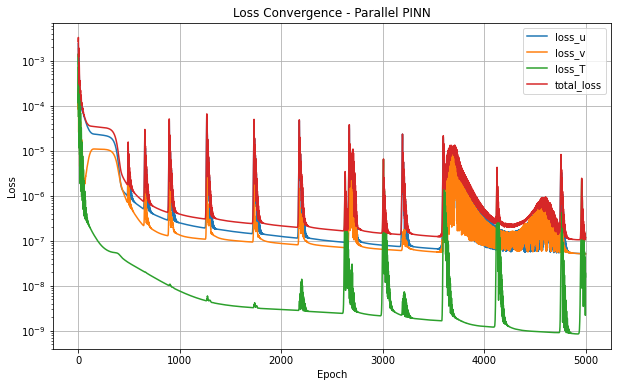

In [36]:
plt.figure(figsize=(10,6))
plt.plot(loss_u_list, label='loss_u')
plt.plot(loss_v_list, label='loss_v')
plt.plot(loss_T_list, label='loss_T')
plt.plot(total_loss_list, label='total_loss')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Convergence - Parallel PINN'); plt.legend(); plt.grid(True)
plt.show()